In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import anndata2ri
import gdown
import scipy
import scipy.io
from rpy2.robjects import r

anndata2ri.activate()

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
    library(SeuratDisk)
    library(Signac)
})

# Expressions

## Load the data

In [5]:
adata = sc.read('../data/sagner-2021/expressions_hvg.h5ad')
adata

AnnData object with n_obs × n_vars = 6334 × 4000
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'count'

In [6]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']
adata_.obs['batch'] = adata.obs['batch']

In [7]:
%%R -i adata_
rna = as.Seurat(adata_, counts='X', data=NULL)
rna

An object of class Seurat 
4000 features across 6334 samples within 1 assay 
Active assay: RNA (4000 features, 0 variable features)


# Peaks

## Load the data

In [9]:
adata = sc.read('../data/sagner-2021/peaks.h5ad')
adata

AnnData object with n_obs × n_vars = 6334 × 38313
    obs: 'nb_features', 'cell_type', 'batch'
    var: 'feature_types', 'genome', 'gene_ids-0', 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'gene_ids-1', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    layers: 'binary'

In [10]:
adata_ = ad.AnnData(adata.layers['binary'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']
adata_.obs['batch'] = adata.obs['batch']

In [11]:
%%R -i adata_
peaks = as.Seurat(adata_, counts='X', data=NULL)
peaks

An object of class Seurat 
38313 features across 6334 samples within 1 assay 
Active assay: RNA (38313 features, 0 variable features)


# Integrate RNA batches
Following https://satijalab.org/seurat/articles/integration_introduction.html

In [12]:
%%R
rna.list <- SplitObject(rna, split.by = "batch")
rna.list <- lapply(X = rna.list, FUN = SCTransform, variable.features.n = 4000)
features <- SelectIntegrationFeatures(object.list = rna.list, nfeatures = 4000)
rna.list <- PrepSCTIntegration(object.list = rna.list, anchor.features = features)

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3483 by 2859

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 2859 cells



  |======================================================================| 100%


R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3483 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3483 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.704511 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==============                                                        |  20%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |==========================================                            |  60%
  |                                                                         

  |======================================================================| 100%


R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3548 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3548 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.74686 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==============                                                        |  20%
  |                                                                            
  |============================                                          |  40%
  |                                                                            
  |==========================================                            |  60%
  |                                                                          

  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~03s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=07s  


In [13]:
%%R
anchors <- FindIntegrationAnchors(object.list = rna.list, normalization.method = "SCT", 
    anchor.features = features)
integrated <- IntegrateData(anchorset = anchors, normalization.method = "SCT")

R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8197 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6134 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 13s


R[write to console]: Merging dataset 1 into 2

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

In [14]:
%%R
integrated <- RunPCA(integrated)

R[write to console]: PC_ 1 
Positive:  PLXDC2, VCAN, SLC8A1, FCN1, LRMDA, RBM47, LYN, MCTP1, AC020916.1, DMXL2 
	   CSF3R, IRAK3, PSAP, SAT1, NEAT1, CD83, HDAC9, PLAUR, SLC11A1, MARCH1 
	   RRP12, CLEC12A, FGD4, HLA-DRA, PID1, LRRK2, CLEC7A, CREB5, GRK3, CST3 
Negative:  SKAP1, CD247, PRKCH, BCL11B, CAMK4, RORA, IL7R, INPP4B, TC2N, SYNE2 
	   LEF1, CD96, THEMIS, STAT4, ANK3, TXK, GNLY, PRKCQ, ITK, BACH2 
	   TRAC, SLFN12L, BCL2, PRF1, CD69, ETS1, SCML4, LINC01934, NCALD, TCF7 
PC_ 2 
Positive:  BANK1, AFF3, CD79A, MS4A1, IGHM, EBF1, RALGPS2, PAX5, FCRL1, OSBPL10 
	   IGHD, BACH2, COL19A1, BLK, LINC00926, CD74, HLA-DQA1, LIX1-AS1, CD79B, ADAM28 
	   HLA-DQB1, HLA-DRA, HLA-DRB1, GNG7, COBLL1, NIBAN3, PLEKHG1, LARGE1, IGKC, KHDRBS2 
Negative:  GNLY, PRF1, NKG7, AOAH, PLCB1, FGFBP2, ARHGAP26, SPON2, CCL5, KLRD1 
	   GZMA, CD247, GZMB, CST7, GZMH, TGFBR3, CTSW, BNC2, NEAT1, PRKCH 
	   IL2RB, ADGRG1, NCALD, KLRF1, MYOM2, PPP2R2B, PLXDC2, FCGR3A, CCL4, PDGFD 
PC_ 3 
Positive:  GNLY, PRF1, NKG

# Integrate ATAC-seq batches

In [15]:
%%R
peaks.list <- SplitObject(peaks, split.by = "batch")

for (i in 1:length(peaks.list)) {
    peaks.list[[i]] <- RunTFIDF(peaks.list[[i]])
    peaks.list[[i]] <- FindTopFeatures(peaks.list[[i]], min.cutoff = 50)
}

R[write to console]: Performing TF-IDF normalization

R[write to console]: Performing TF-IDF normalization



In [16]:
%%R
for (i in 1:length(peaks.list)) {
    peaks.list[[i]] <- RunSVD(peaks.list[[i]])
}

R[write to console]: Running SVD

R[write to console]: Scaling cell embeddings

R[write to console]: Running SVD

R[write to console]: Scaling cell embeddings



In [17]:
%%R
anchors <- FindIntegrationAnchors(
  object.list = peaks.list,
  anchor.features = rownames(peaks.list[[1]]),
  k.filter = NA
)

R[write to console]: Scaling features for provided objects



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~32s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01m 08s


R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8779 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=56s  


In [18]:
%%R
integrated_atac <- IntegrateData(
  anchorset = anchors,
  weight.reduction = 'lsi',
  dims = 2:30,
  preserve.order = TRUE
)

R[write to console]: Merging dataset 2 into 1

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

In [19]:
%%R
integrated_atac <- RunSVD(integrated_atac, n = 30, reduction.name = 'integratedLSI')

R[write to console]: Running SVD

R[write to console]: Scaling cell embeddings



# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [20]:
%%R
integrated[["IATAC"]] <- integrated_atac[["integrated"]]
integrated[["integratedLSI"]] <- integrated_atac[["integratedLSI"]]

integrated <- FindMultiModalNeighbors(integrated, reduction.list = list("pca", "integratedLSI"), 
                              dims.list = list(1:50, 2:30), modality.weight.name = "RNA.weight")

integrated <- RunSPCA(integrated, assay = 'integrated', graph = 'wsnn', npcs = 20)

SaveH5Seurat(integrated, 'sagner-seurat.h5seurat', overwrite = TRUE)

R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=08s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~11s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=26s  
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~02s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Computing sPCA transformation

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA

R[write to console]: Adding counts for SCT

R[write to console]: Adding data for SCT

R[write to console]: Adding scale.data for SCT

R[write to console]: No variable features found for SCT

R[write to console]: No feature-level metadata found for SCT

R[write to console]: Writing out SCTModel.list for SCT

R[write to console]: Adding data for integrated

R[write to console]: Adding scale.data for integrated

R[write to console]: Adding variable features for integrated

R[write to console]: No feature-level metadata found for integrated

R[write to console]

In [30]:
# otherwise convertion to an AnnData object throws errors
%%R
integrated[["integratedLSI"]] <- NULL

In [31]:
%%R
SaveH5Seurat(integrated, 'sagner-seurat.h5seurat', overwrite = TRUE)

R[write to console]: Warning:
R[write to console]:  Overwriting previous file sagner-seurat.h5seurat

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA

R[write to console]: Adding counts for SCT

R[write to console]: Adding data for SCT

R[write to console]: Adding scale.data for SCT

R[write to console]: No variable features found for SCT

R[write to console]: No feature-level metadata found for SCT

R[write to console]: Writing out SCTModel.list for SCT

R[write to console]: Adding data for integrated

R[write to console]: Adding scale.data for integrated

R[write to console]: Adding variable features for integrated

R[write to console]: No feature-level metadata found for integrated

R[write to console]: Writing out SCTModel.list for integrated

R[write to console

In [32]:
%%R
Convert("sagner-seurat.h5seurat", assay="integrated", "sagner-seurat.h5ad", overwrite=TRUE)

R[write to console]: Validating h5Seurat file

R[write to console]: Adding scale.data from integrated as X

R[write to console]: Adding data from integrated as raw

R[write to console]: Transfering meta.data to obs

R[write to console]: Adding dimensional reduction information for pca

R[write to console]: Adding feature loadings for pca

R[write to console]: Adding dimensional reduction information for spca

R[write to console]: Adding feature loadings for spca

R[write to console]: Adding wsnn as neighbors

R[write to console]: Adding scale.data from SCT as a layer



In [33]:
integrated = sc.read('sagner-seurat.h5ad')
integrated

AnnData object with n_obs × n_vars = 6334 × 3361
    obs: 'cell_type', 'batch', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'integrated.weight'
    var: 'features', 'SCT_features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_spca'
    varm: 'PCs', 'SPCA'
    layers: 'SCT'
    obsp: 'distances'

In [35]:
latent = sc.AnnData(integrated.obsm['X_spca'])
latent.obs = integrated.obs
latent.obsp['connectivities'] = integrated.uns['neighbors']['distances']

In [36]:
latent.write('../data/integrated/seurat/sagner-seurat.h5ad')

... storing 'cell_type' as categorical
... storing 'batch' as categorical


In [37]:
!rm 'sagner-seurat.h5seurat'
!rm 'sagner-seurat.h5ad'

In [38]:
%%R
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /mnt/home/icb/anastasia.litinetskaya/miniconda3/envs/signac/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Matrix_1.3-2                Signac_1.1.1               
 [3] SeuratDisk_0.0.0.9018       SeuratObject_4.0.0         
 [5] Seurat_4.0.0                SingleCellExperiment_1.12.0
 [7] SummarizedExperiment_1.20.0 Biobase_2.50.0           

# Visualize results

In [39]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

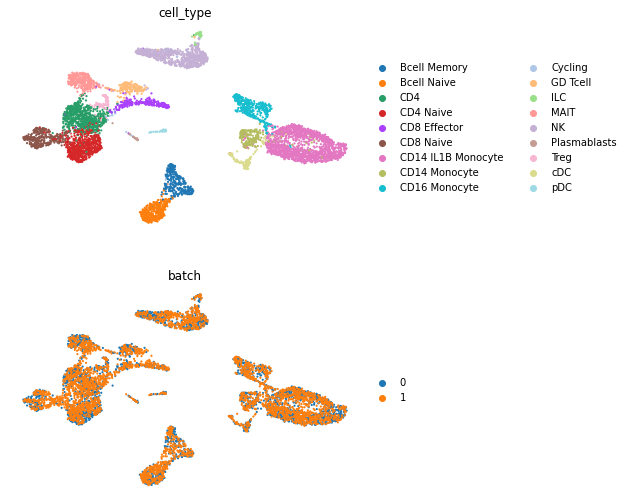

In [40]:
sc.pl.umap(latent, color=['cell_type', 'batch'], frameon=False, ncols=1)